In [2]:
!pip install QuantLib-Python

#### The first Method

In [3]:
import numpy as np 
import math 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [4]:
import QuantLib as ql

calendar = ql.TARGET()
todaysDate = ql.Date(15, ql.May, 2007)
ql.Settings.instance().evaluationDate = todaysDate

risk_free_rate = ql.YieldTermStructureHandle(ql.FlatForward(todaysDate, 0.005, ql.Actual360(), ql.Compounded, ql.Quarterly))

# ### CDS parameters

recovery_rate = 0.7
quoted_spreads = [0.0160, 0.0180, 0.0200, 0.0210, 0.0250]
tenors = [ql.Period(1, ql.Years),ql.Period(3, ql.Years),ql.Period(5, ql.Years),ql.Period(7, ql.Years), ql.Period(10, ql.Years)]
maturities = [calendar.adjust(todaysDate + x, ql.Following) for x in tenors]

instruments = [
    ql.SpreadCdsHelper(
        ql.QuoteHandle(ql.SimpleQuote(s)),
        tenor,
        0,
        calendar,
        ql.Quarterly,
        ql.Following,
        ql.DateGeneration.TwentiethIMM,
        ql.Actual360(),
        recovery_rate,
        risk_free_rate,
    )
    for s, tenor in zip(quoted_spreads, tenors)
]

hazard_curve = ql.PiecewiseFlatHazardRate(todaysDate, instruments, ql.Actual360())
print("Calibrated hazard rate values: ")

for x in hazard_curve.nodes():
    print("hazard rate on %s is %.7f" % x)

Calibrated hazard rate values: 
hazard rate on May 15th, 2007 is 0.0533004
hazard rate on June 20th, 2008 is 0.0533004
hazard rate on June 21st, 2010 is 0.0640219
hazard rate on June 20th, 2012 is 0.0791497
hazard rate on June 20th, 2014 is 0.0813651
hazard rate on June 20th, 2017 is 0.1360746


In [5]:
hazard_curve

<QuantLib.QuantLib.PiecewiseFlatHazardRate; proxy of <Swig Object of type 'ext::shared_ptr< PiecewiseFlatHazardRate > *' at 0x000001D2034D6FC0> >

In [9]:
df = pd.DataFrame( hazard_curve.nodes() )
df[0] = np.array([0, 1,3,5,7,10])
df = df.rename(columns = {0:"Time",1:'Forward Hazard Rate'}) 

In [10]:
df

,Time,Forward Hazard Rate
0,0,0.053300
1,1,0.053300
2,3,0.064022
3,5,0.079150
4,7,0.081365
5,10,0.136075


In [11]:
df['Forward Hazard Rate'][0] = 0
df['Survival'] = 1.0
df['Time_diff'] = df['Time'].diff()

In [12]:
df

,Time,Forward Hazard Rate,Survival,Time_diff
0,0,0.000000,1.0,NaN
1,1,0.053300,1.0,1.0
2,3,0.064022,1.0,2.0
3,5,0.079150,1.0,2.0
4,7,0.081365,1.0,2.0
5,10,0.136075,1.0,3.0


In [379]:
df['Forward Hazard Rate'][0] = 0
df['Survival'] = 1.0
df['Time_diff'] = df['Time'].diff()
for i in range(1,6):
    df['Survival'][i] = np.exp(-df['Forward Hazard Rate'][i] * df['Time_diff'][i]) * df['Survival'][i-1]
df['Survival'] = pd.to_numeric(df['Survival'],downcast='float')
df['Cumulative Default Probability'] = 1 - df['Survival']
df['Cumulative Hazard Rate'] = -np.log(df['Survival']) / df['Time']
df['CDS Rate (in bps)'] = np.array([0,160,180,200,210,250])
df = df.drop([0])
cols = ['Time', 'CDS Rate (in bps)', 'Forward Hazard Rate', 'Cumulative Hazard Rate','Cumulative Default Probability']
df = df[cols]
df

,Time,CDS Rate (in bps),Forward Hazard Rate,Cumulative Hazard Rate,Cumulative Default Probability
1,1,160,0.053300,0.053300,0.051905
2,3,180,0.064022,0.060448,0.165852
3,5,200,0.079150,0.067929,0.287976
4,7,210,0.081365,0.071768,0.394907
5,10,250,0.136075,0.091060,0.597716


In [385]:
df_simple = pd.read_excel('D:\QRM_Program\Credit\case2\Simple_Method.xlsx')
df_simple

,Time,CDS Rate,Lambda Cumulative,Q(t>T),Forward hazard Rate,Default Probability
0,1,0.016,0.053333,0.948064,0.053333,0.051936
1,3,0.018,0.060000,0.835270,0.063333,0.164730
2,5,0.020,0.066667,0.716531,0.076667,0.283469
3,7,0.021,0.070000,0.612626,0.078333,0.387374
4,10,0.025,0.083333,0.434598,0.114444,0.565402


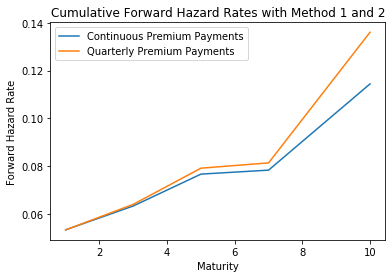

In [404]:
X = np.array(df['Time'])
Y1 = np.array(df_simple['Forward hazard Rate'])
Y2 = np.array(df['Forward Hazard Rate'])
plt.plot(X, Y1,label = 'Continuous Premium Payments')
plt.plot(X, Y2,label = 'Quarterly Premium Payments')
plt.xlabel('Maturity')
plt.ylabel('Forward Hazard Rate')
plt.legend()
plt.title('Cumulative Forward Hazard Rates with Method 1 and 2')
plt.savefig('CumulativeForwardHazardRateswithMethod1and2.jpeg',format='jpeg')
plt.show()

In [380]:
print( df.to_latex(float_format="%.4f",index=False ) )

\begin{tabular}{rrrrr}
\toprule
 Time &  CDS Rate (in bps) &  Forward Hazard Rate &  Cumulative Hazard Rate &  Cumulative Default Probability \\
\midrule
    1 &                160 &               0.0533 &                  0.0533 &                          0.0519 \\
    3 &                180 &               0.0640 &                  0.0604 &                          0.1659 \\
    5 &                200 &               0.0791 &                  0.0679 &                          0.2880 \\
    7 &                210 &               0.0814 &                  0.0718 &                          0.3949 \\
   10 &                250 &               0.1361 &                  0.0911 &                          0.5977 \\
\bottomrule
\end{tabular}

